In [1]:
from pymavlink import mavutil
import math
import tkinter as tk
import socket
import time
import helper
import threading
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
SIM_COMPUTER_IP = '192.168.1.110'  # IP address of the simulation computer
PORT = 15000  # The same port as used by the server

In [3]:
def send_command(command):
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.connect((SIM_COMPUTER_IP, PORT))
        s.sendall(command.encode('utf-8'))

def start_instance(instance_id, out_port):
    send_command(f"start {instance_id} {out_port}")

def stop_instance(instance_id):
    send_command(f"stop {instance_id}")

def connect(port):
    connection = mavutil.mavlink_connection(f'udpin:0.0.0.0:{port}') 

    connection.wait_heartbeat() #wait until we hear a heartbeat from the copter

    return connection 

def get_current_position(connection):

    msg = connection.recv_match(type='LOCAL_POSITION_NED', blocking=True)

    north = msg.x
    east = msg.y
    down = -msg.z

    return(north, east, down)

def wait_for_gps_lock(connection, timeout=60):
    start_time = time.time()
    while True:
        # Check for timeout
        if time.time() - start_time > timeout:
            print("Timeout waiting for GPS lock.")
            return False
            
        # Fetch GPS_RAW_INT messages
        msg = connection.recv_match(type='GPS_RAW_INT', blocking=True, timeout=5)
        if not msg:
            print("No GPS data received.")
            continue
            
        # Check for 3D lock
        if msg.fix_type >= 3:
            print(f"GPS lock acquired with {msg.satellites_visible} satellites.")
            return True
        else:
            print(f"Current GPS fix type: {msg.fix_type}, waiting for 3D lock...")

        time.sleep(1)


def arm(mavlink_connection):
    """
    Arms vehicle and fly to a target altitude.
    :param mavlink_connection: The connection to the vehicle
    :param target_altitude: Target altitude in meters
    """

    print("Basic pre-arm checks")
    # Wait for vehicle to initialize and become ready
    while not mavlink_connection.wait_heartbeat(timeout=5):
        print("Waiting for vehicle heartbeat")

           
    print("Setting vehicle to GUIDED mode")
    mavlink_connection.mav.set_mode_send(mavlink_connection.target_system, mavutil.mavlink.MAV_MODE_FLAG_CUSTOM_MODE_ENABLED, 4) 

    # Wait a bit for the mode to change
    time.sleep(2)

    # Copter should arm in GUIDED mode
    mavlink_connection.mav.command_long_send(
        mavlink_connection.target_system, mavlink_connection.target_component,
        mavutil.mavlink.MAV_CMD_COMPONENT_ARM_DISARM,
        0,  # Confirmation
        1,  # 1 to arm
        0, 0, 0, 0, 0, 0  # Unused parameters for this command
    )
def waitForEKF2(connection):
    while True:
        msg = connection.recv_match(type='STATUSTEXT', blocking=True, timeout=5)
        if msg is None:
            continue
        text = msg.text.decode('utf-8')
        if "EKF2 IMU0 is using GPS" in text:
            print("Received EKF2 GPS lock message.")
            return True

def takeoff(mavlink_connection, alt):
    #Assumes you have already set to guided mode and armed.

    mavlink_connection.mav.command_long_send(mavlink_connection.target_system, mavlink_connection.target_component, 
                                 mavutil.mavlink.MAV_CMD_NAV_TAKEOFF, 0, 0, 0, 0, 0, 0, 0, alt)
    
    #See how the copter responded to the takeoff command
    msg = mavlink_connection.recv_match(type = 'COMMAND_ACK', blocking = True)
    #print(msg)

    while True:
        # Wait for the next LOCAL_POSITION_NED message
        msg = mavlink_connection.recv_match(type='LOCAL_POSITION_NED', blocking=True)
        
    
        # Check if altitude is within a threshold of the target altitude
        if abs(msg.z * -1 - alt) < 1.0:
            print("Reached target altitude")
            break

#send local frame coordinates and have copter fly over that spot.
def send_waypoint_local(connection, x, y, alt):
    connection.mav.send(mavutil.mavlink.MAVLink_set_position_target_local_ned_message
                    (10, connection.target_system, connection.target_component, mavutil.mavlink.MAV_FRAME_LOCAL_NED, 
                     int(0b010111111000), x, y, alt,
                      0, 0, 0, 0, 0, 0, 0, 0))

    time.sleep(1)


In [4]:
def plot_3d_paths(results):
    # Create a new figure for plotting
    fig = plt.figure(figsize=(10, 8))
    
    # Determine the number of subplots based on the number of paths
    num_paths = len(results)
    cols = 2  # You can adjust the number of columns based on your preference
    rows = (num_paths + cols - 1) // cols  # Calculate rows needed
    
    x_limits = (-10, 10)
    y_limits = (-10, 10)
    z_limits = (-10, 10)
    
    # Plot each path in a subplot
    for index, (pid, path) in enumerate(results.items(), start=1):
        ax = fig.add_subplot(rows, cols, index, projection='3d')
        # Assuming path is a list of [north, east, down] coordinates
        path = np.array(path)  # Convert path to a NumPy array for easier slicing
        
        # Create a color map
        points = np.arange(len(path))
        colors = cm.plasma(points / max(points))  # Normalize points for color mapping
        
        # Plot the 3D path with a color gradient
        ax.scatter(path[:, 0], path[:, 1], path[:, 2], c=colors, cmap='plasma', marker='o')
        
        # Plot the target point in red
        ax.plot([5], [5], [9], marker='o', color='red', markersize=10)
        
        ax.set_xlim(x_limits)
        ax.set_ylim(y_limits)
        ax.set_zlim(z_limits)
        
        ax.set_xlabel('North')
        ax.set_ylabel('East')
        ax.set_zlabel('Down')
        ax.set_title(f'PID {pid} Flight Path')

    plt.tight_layout()
    plt.show()


In [5]:
# GANN definitions #

class DroneNet(nn.Module):
    def __init__(self):
        super(DroneNet, self).__init__()
        self.fc1 = nn.Linear(3, 10)  # First hidden layer from 3 inputs to 10 nodes
        self.fc2 = nn.Linear(10, 5)  # Second hidden layer from 10 nodes to 5 nodes
        self.output = nn.Linear(5, 3)  # Output layer from 5 nodes to 3 outputs (NED coordinates)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # ReLu activation for first hidden layer
        x = torch.relu(self.fc2(x))  # ReLu activation for second hidden layer
        x = self.output(x)  # Output layer, no activation (linear output)
        return x
    
def get_fitness(path, target):
    # calculate how close final position was to target and the total distance.
    # return a fitness that rewards closeness to target and minumum distance flown.
    final_position = path[-1]
    fp_north, fp_east, fp_down = final_position
    t_north, t_east, t_down = target

    distance_from_target = np.sqrt((fp_north-t_north)**2 + (fp_east-t_east)**2 + (fp_down-t_down)**2)

    total_distance = 0
    for i in range(1, len(path)):
        n, e, d = path[i]
        old_n, old_e, old_d = path[i-1]

        total_distance += np.sqrt((old_n-n)**2 + (old_e-e)**2 + (old_d-d)**2)
        
    distance_target_score = 1 / (distance_from_target + 1)
    distance_total_score = 1 / (total_distance + 1) 
    
    if distance_from_target > 20:
        distance_target_score = distance_target_score - 0.75
        
    distance_target_score = 1 / (distance_from_target + 1)
    
    fitness = distance_target_score + distance_total_score
    
    print(f"Fitness: {fitness} dist_from_target = {distance_from_target} and total_distace = {total_distance}")
    
    return fitness

def mutate(network, mutation_rate, mutation_strength):
    with torch.no_grad():
        for param in network.parameters():
            if random.random() < mutation_rate:
                mutation = torch.randn_like(param) * mutation_strength
                param.add_(mutation)

def crossover(parent1, parent2):
    child = DroneNet() 
    with torch.no_grad():
        for child_param, param1, param2 in zip(child.parameters(), parent1.parameters(), parent2.parameters()):
            mask = torch.bernoulli(torch.full_like(param1, 0.5))  # Randomly take weights from either parent
            child_param.data.copy_(param1.data * mask + param2.data * (1 - mask))
    return child

def initialize_population(size):
    return [DroneNet() for _ in range(size)]

def generate_new_population(population, fitness_scores, mutation_rate, mutation_strength):
    new_population = []
    population_size = len(population)
    
    # Select the best 2 dudes
    # Select the best 2 dudes
    for i in range(len(fitness_scores)):
        print(f"Instance {i}: {fitness_scores[i]}")

    
    sorted_indices = sorted(range(len(fitness_scores)), key=lambda k: fitness_scores[k], reverse=True)
    for i in sorted_indices:
        print(f"indice: {i} {fitness_scores[i]}")
        
    elite = [population[i] for i in sorted_indices[:2]]

    # Crossover and mutation to fill the new population
    while len(new_population) < population_size - len(elite):
        parent1, parent2 = random.sample(elite, 2)
        child = crossover(parent1, parent2)
        mutate(child, mutation_rate, mutation_strength)
        new_population.append(child)

    # Ensure that the total new population size does not exceed the original population size
    new_population.extend(elite[:population_size - len(new_population)])

    return new_population

def adjust_output(output):
    # Scale from [0, 1] to [1, 50]
    return 1 + 49 * output


Testing selection top 2 guys to crossover instead of top half of population
Mutation rate is 0.1 and mutation strength is 0.1
<----------------------- EPOCH 0 ------------------------->
starting instance 0 on port 14560
starting instance 1 on port 14561
starting instance 2 on port 14562
starting instance 3 on port 14563
starting instance 4 on port 14564
starting instance 5 on port 14565
instance 4 - Heartbeat Recieved!
instance 0 - Heartbeat Recieved!
instance 1 - Heartbeat Recieved!
instance 5 - Heartbeat Recieved!
instance 3 - Heartbeat Recieved!
instance 2 - Heartbeat Recieved!
instance 4 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 0 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 1 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 5 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 3 - arming thro

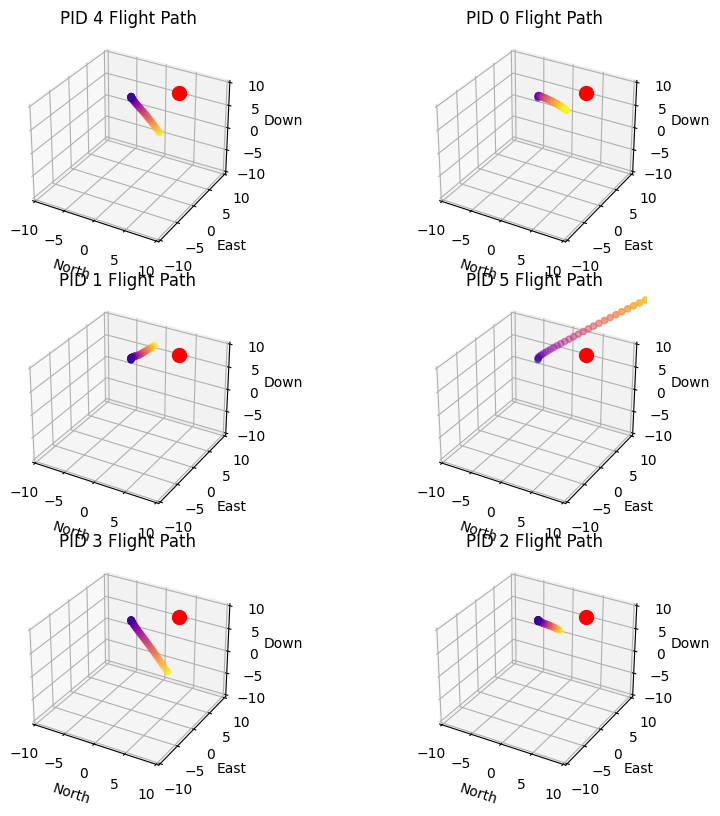

Instance 0: 0.07879740579419961
Instance 1: 0.12087225605010214
Instance 2: 0.13653637269649127
Instance 3: 0.17128352496079224
Instance 4: 0.18043710327245607
Instance 5: 0.09001993684076284
indice: 4 0.18043710327245607
indice: 3 0.17128352496079224
indice: 2 0.13653637269649127
indice: 1 0.12087225605010214
indice: 5 0.09001993684076284
indice: 0 0.07879740579419961
<----------------------- EPOCH 1 ------------------------->
starting instance 6 on port 14566
starting instance 7 on port 14567
starting instance 8 on port 14568
starting instance 9 on port 14569
starting instance 10 on port 14570
starting instance 11 on port 14571
instance 11 - Heartbeat Recieved!
instance 7 - Heartbeat Recieved!
instance 9 - Heartbeat Recieved!
instance 6 - Heartbeat Recieved!
instance 10 - Heartbeat Recieved!
instance 8 - Heartbeat Recieved!
instance 11 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 7 - arming throttle in GUIDED mode.
Basic pre-arm check

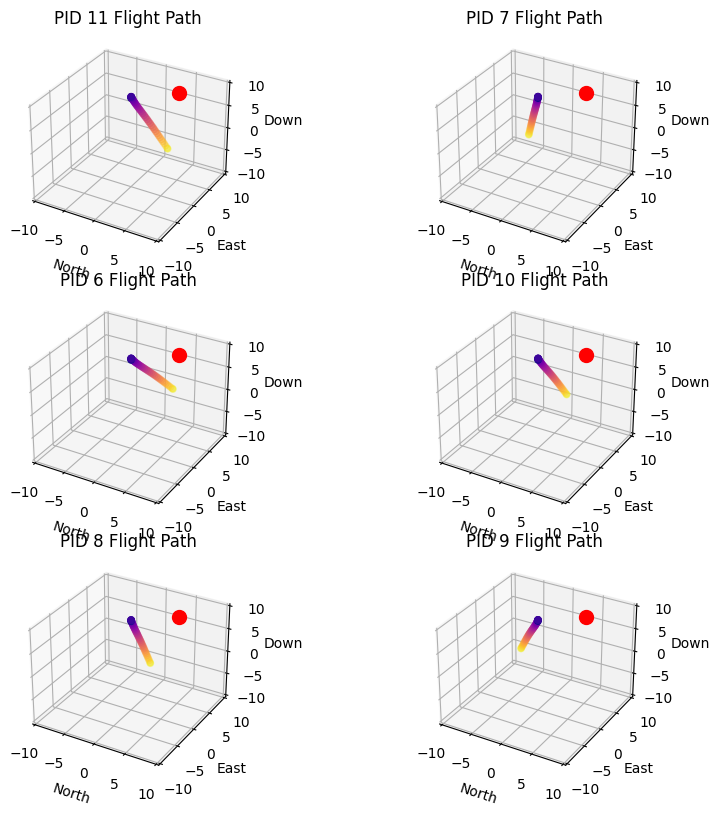

Instance 0: 0.17369318215222768
Instance 1: 0.16576238585067682
Instance 2: 0.1803171410022425
Instance 3: 0.15196141107087555
Instance 4: 0.1805054232066648
Instance 5: 0.17132110888035867
indice: 4 0.1805054232066648
indice: 2 0.1803171410022425
indice: 0 0.17369318215222768
indice: 5 0.17132110888035867
indice: 1 0.16576238585067682
indice: 3 0.15196141107087555
<----------------------- EPOCH 2 ------------------------->
starting instance 12 on port 14572
starting instance 13 on port 14573
starting instance 14 on port 14574
starting instance 15 on port 14575
starting instance 16 on port 14576
starting instance 17 on port 14577
instance 13 - Heartbeat Recieved!
instance 12 - Heartbeat Recieved!
instance 15 - Heartbeat Recieved!
instance 16 - Heartbeat Recieved!
instance 17 - Heartbeat Recieved!
instance 14 - Heartbeat Recieved!
instance 12 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 13 - arming throttle in GUIDED mode.
Basic pre-arm 

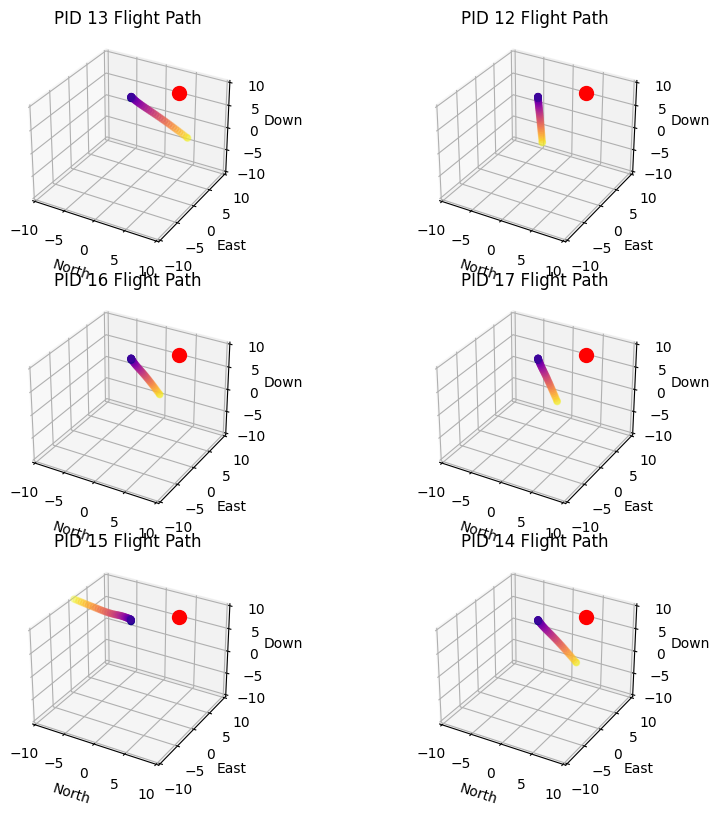

Instance 0: 0.17364414882522278
Instance 1: 0.17127071700471128
Instance 2: 0.1800041363623836
Instance 3: 0.09743736615235658
Instance 4: 0.1805906036898597
Instance 5: 0.18003152815955625
indice: 4 0.1805906036898597
indice: 5 0.18003152815955625
indice: 2 0.1800041363623836
indice: 0 0.17364414882522278
indice: 1 0.17127071700471128
indice: 3 0.09743736615235658
<----------------------- EPOCH 3 ------------------------->
starting instance 18 on port 14578
starting instance 19 on port 14579
starting instance 20 on port 14580
starting instance 21 on port 14581
starting instance 22 on port 14582
starting instance 23 on port 14583
instance 19 - Heartbeat Recieved!
instance 21 - Heartbeat Recieved!
instance 23 - Heartbeat Recieved!
instance 20 - Heartbeat Recieved!
instance 22 - Heartbeat Recieved!
instance 18 - Heartbeat Recieved!
instance 19 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 21 - arming throttle in GUIDED mode.
Basic pre-arm 

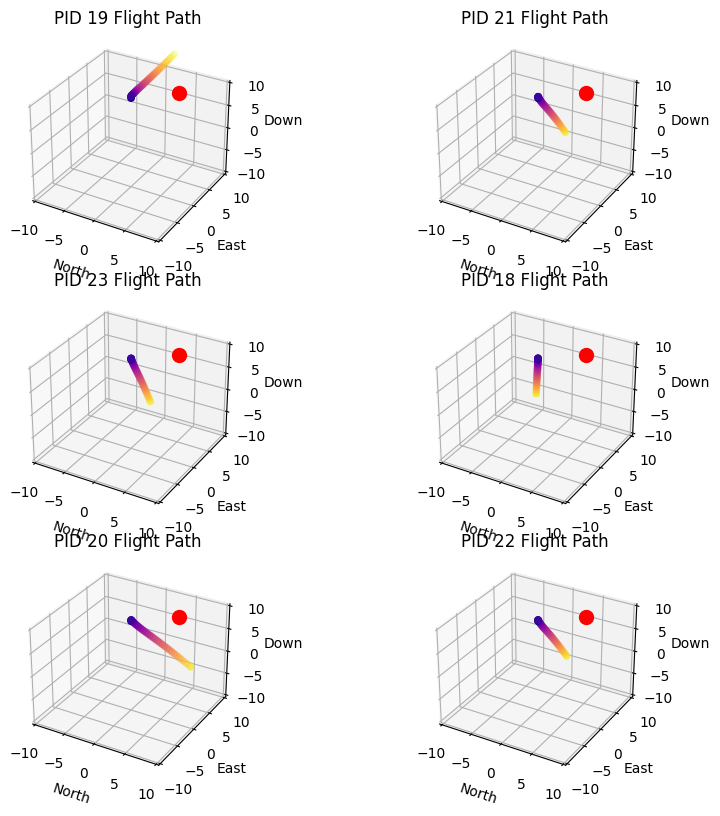

Instance 0: 0.1698562606384699
Instance 1: 0.1069108200576193
Instance 2: 0.16653012209258783
Instance 3: 0.18017564804323105
Instance 4: 0.18075790921928164
Instance 5: 0.18023568519376568
indice: 4 0.18075790921928164
indice: 5 0.18023568519376568
indice: 3 0.18017564804323105
indice: 0 0.1698562606384699
indice: 2 0.16653012209258783
indice: 1 0.1069108200576193
<----------------------- EPOCH 4 ------------------------->
starting instance 24 on port 14584
starting instance 25 on port 14585
starting instance 26 on port 14586
starting instance 27 on port 14587
starting instance 28 on port 14588
starting instance 29 on port 14589
instance 25 - Heartbeat Recieved!
instance 26 - Heartbeat Recieved!
instance 24 - Heartbeat Recieved!
instance 27 - Heartbeat Recieved!
instance 28 - Heartbeat Recieved!
instance 29 - Heartbeat Recieved!
instance 25 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 26 - arming throttle in GUIDED mode.
Basic pre-arm 

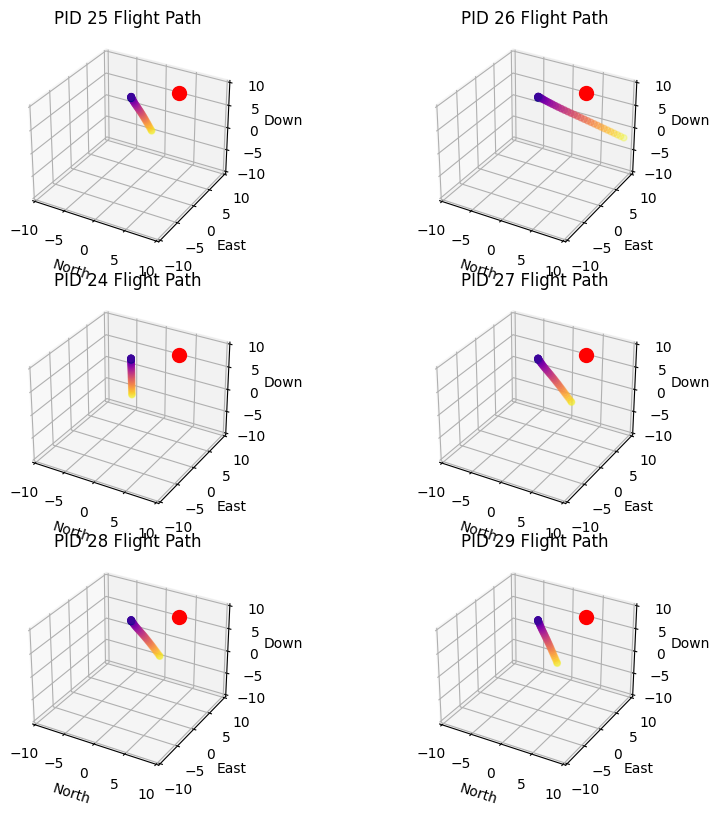

Instance 0: 0.171679978575148
Instance 1: 0.17805237240186045
Instance 2: 0.1477364339891736
Instance 3: 0.18016275762054013
Instance 4: 0.1805476960492497
Instance 5: 0.1801155562781114
indice: 4 0.1805476960492497
indice: 3 0.18016275762054013
indice: 5 0.1801155562781114
indice: 1 0.17805237240186045
indice: 0 0.171679978575148
indice: 2 0.1477364339891736
<----------------------- EPOCH 5 ------------------------->
starting instance 30 on port 14590
starting instance 31 on port 14591
starting instance 32 on port 14592
starting instance 33 on port 14593
starting instance 34 on port 14594
starting instance 35 on port 14595
instance 32 - Heartbeat Recieved!
instance 35 - Heartbeat Recieved!
instance 33 - Heartbeat Recieved!
instance 34 - Heartbeat Recieved!
instance 30 - Heartbeat Recieved!
instance 31 - Heartbeat Recieved!
instance 32 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 35 - arming throttle in GUIDED mode.
Basic pre-arm checks

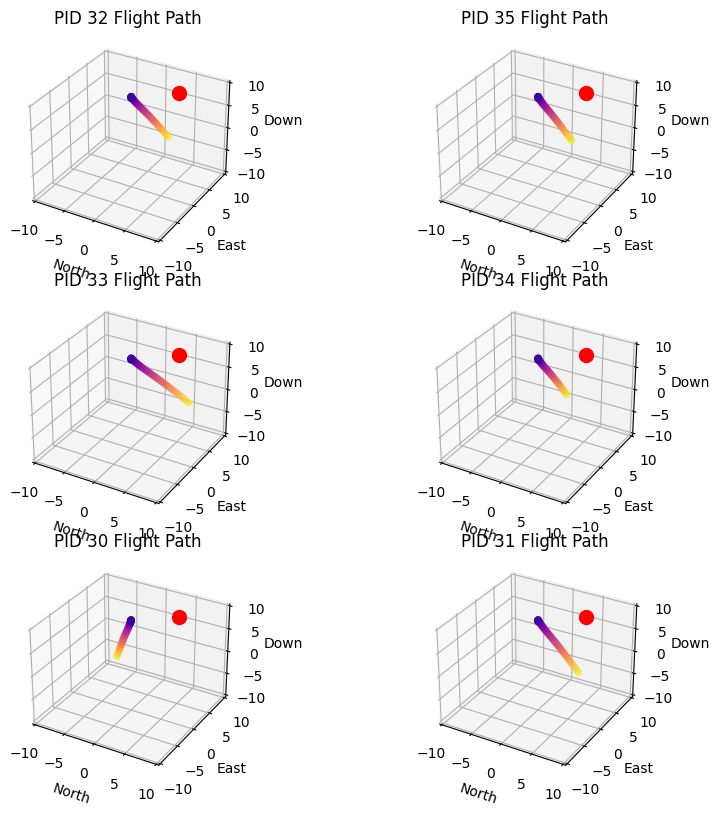

Instance 0: 0.16113121952882115
Instance 1: 0.16976820577103735
Instance 2: 0.1808969425305847
Instance 3: 0.1694614620109993
Instance 4: 0.18051074129107422
Instance 5: 0.18027490139210817
indice: 2 0.1808969425305847
indice: 4 0.18051074129107422
indice: 5 0.18027490139210817
indice: 1 0.16976820577103735
indice: 3 0.1694614620109993
indice: 0 0.16113121952882115
<----------------------- EPOCH 6 ------------------------->
starting instance 36 on port 14596
starting instance 37 on port 14597
starting instance 38 on port 14598
starting instance 39 on port 14599
starting instance 40 on port 14600
starting instance 41 on port 14601
instance 40 - Heartbeat Recieved!
instance 38 - Heartbeat Recieved!
instance 41 - Heartbeat Recieved!
instance 39 - Heartbeat Recieved!
instance 37 - Heartbeat Recieved!
instance 36 - Heartbeat Recieved!
instance 40 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 38 - arming throttle in GUIDED mode.
Basic pre-arm 

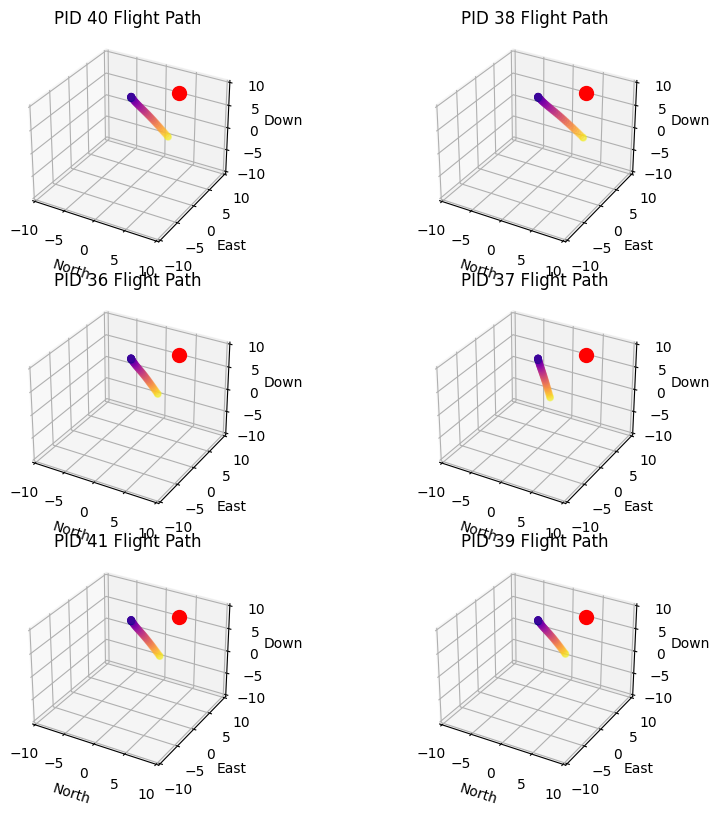

Instance 0: 0.18031063573471315
Instance 1: 0.1783698809901501
Instance 2: 0.17807186425805083
Instance 3: 0.1789736878876225
Instance 4: 0.18057147219266384
Instance 5: 0.1805576595524433
indice: 4 0.18057147219266384
indice: 5 0.1805576595524433
indice: 0 0.18031063573471315
indice: 3 0.1789736878876225
indice: 1 0.1783698809901501
indice: 2 0.17807186425805083
<----------------------- EPOCH 7 ------------------------->
starting instance 42 on port 14602
starting instance 43 on port 14603
starting instance 44 on port 14604
starting instance 45 on port 14605
starting instance 46 on port 14606
starting instance 47 on port 14607
instance 44 - Heartbeat Recieved!
instance 45 - Heartbeat Recieved!
instance 43 - Heartbeat Recieved!
instance 47 - Heartbeat Recieved!
instance 46 - Heartbeat Recieved!
instance 42 - Heartbeat Recieved!
instance 44 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 45 - arming throttle in GUIDED mode.
Basic pre-arm ch

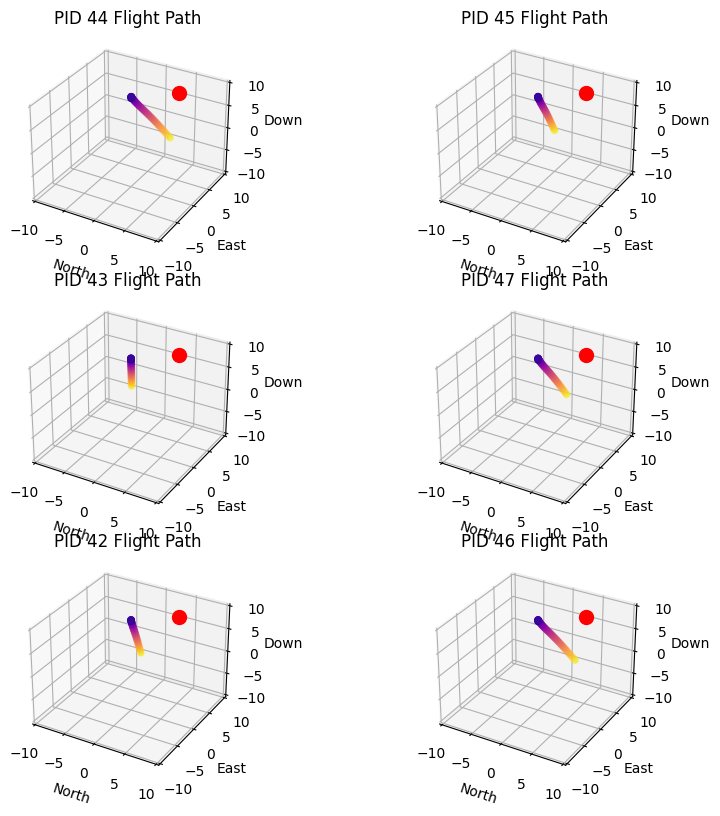

Instance 0: 0.17355918784655416
Instance 1: 0.16222928899239175
Instance 2: 0.18008613564502568
Instance 3: 0.1768878260744565
Instance 4: 0.18086265768088375
Instance 5: 0.18055433674798405
indice: 4 0.18086265768088375
indice: 5 0.18055433674798405
indice: 2 0.18008613564502568
indice: 3 0.1768878260744565
indice: 0 0.17355918784655416
indice: 1 0.16222928899239175
<----------------------- EPOCH 8 ------------------------->
starting instance 48 on port 14608
starting instance 49 on port 14609
starting instance 50 on port 14610
starting instance 51 on port 14611
starting instance 52 on port 14612
starting instance 53 on port 14613
instance 52 - Heartbeat Recieved!
instance 49 - Heartbeat Recieved!
instance 50 - Heartbeat Recieved!
instance 51 - Heartbeat Recieved!
instance 48 - Heartbeat Recieved!
instance 53 - Heartbeat Recieved!
instance 52 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 49 - arming throttle in GUIDED mode.
Basic pre-ar

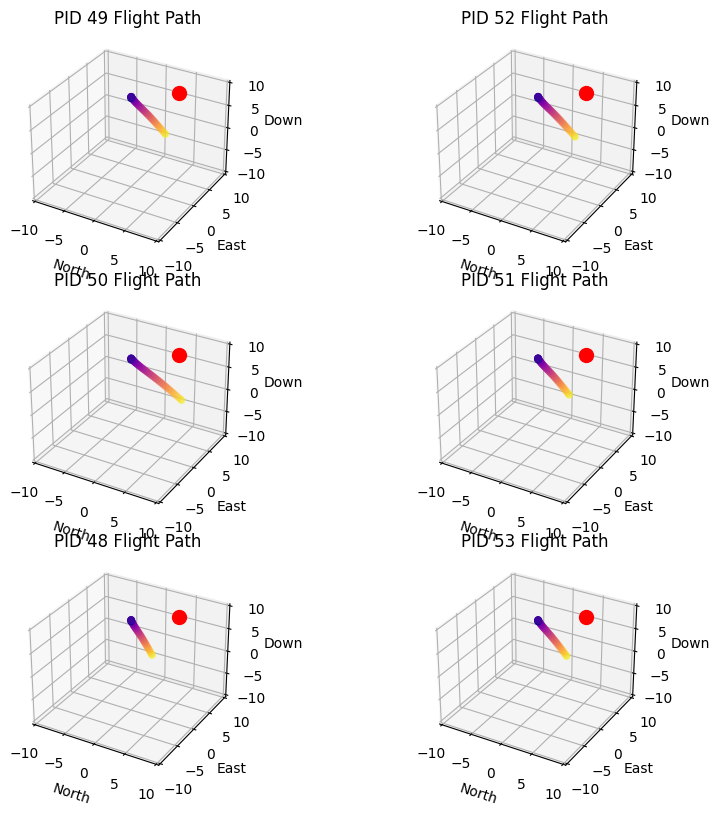

Instance 0: 0.17898741392003853
Instance 1: 0.18078055240400992
Instance 2: 0.17504182264453305
Instance 3: 0.1807888736667449
Instance 4: 0.18082089515262656
Instance 5: 0.18058061855290178
indice: 4 0.18082089515262656
indice: 3 0.1807888736667449
indice: 1 0.18078055240400992
indice: 5 0.18058061855290178
indice: 0 0.17898741392003853
indice: 2 0.17504182264453305
<----------------------- EPOCH 9 ------------------------->
starting instance 54 on port 14614
starting instance 55 on port 14615
starting instance 56 on port 14616
starting instance 57 on port 14617
starting instance 58 on port 14618
starting instance 59 on port 14619
instance 56 - Heartbeat Recieved!
instance 58 - Heartbeat Recieved!
instance 54 - Heartbeat Recieved!
instance 59 - Heartbeat Recieved!
instance 57 - Heartbeat Recieved!
instance 55 - Heartbeat Recieved!
instance 56 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 58 - arming throttle in GUIDED mode.
Basic pre-ar

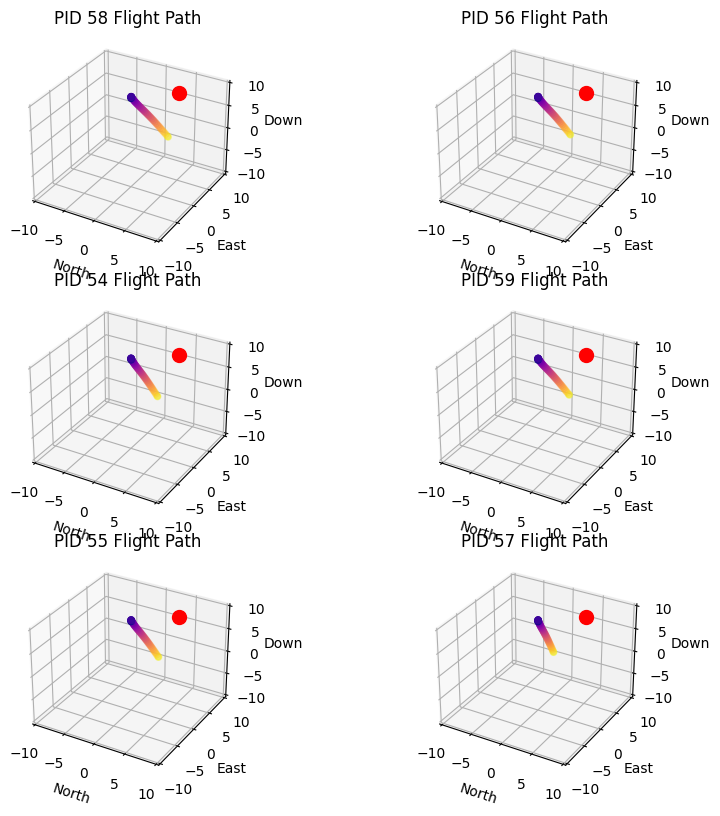

Instance 0: 0.18141345696161765
Instance 1: 0.18105291715108895
Instance 2: 0.18112195655035634
Instance 3: 0.17502790395685663
Instance 4: 0.18055726422691667
Instance 5: 0.18072231432186556
indice: 0 0.18141345696161765
indice: 2 0.18112195655035634
indice: 1 0.18105291715108895
indice: 5 0.18072231432186556
indice: 4 0.18055726422691667
indice: 3 0.17502790395685663
<----------------------- EPOCH 10 ------------------------->
starting instance 60 on port 14620
starting instance 61 on port 14621
starting instance 62 on port 14622
starting instance 63 on port 14623
starting instance 64 on port 14624
starting instance 65 on port 14625
instance 63 - Heartbeat Recieved!
instance 65 - Heartbeat Recieved!instance 60 - Heartbeat Recieved!

instance 62 - Heartbeat Recieved!
instance 64 - Heartbeat Recieved!
instance 63 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 60 - arming throttle in GUIDED mode.instance 65 - arming throttle in GUIDED mode

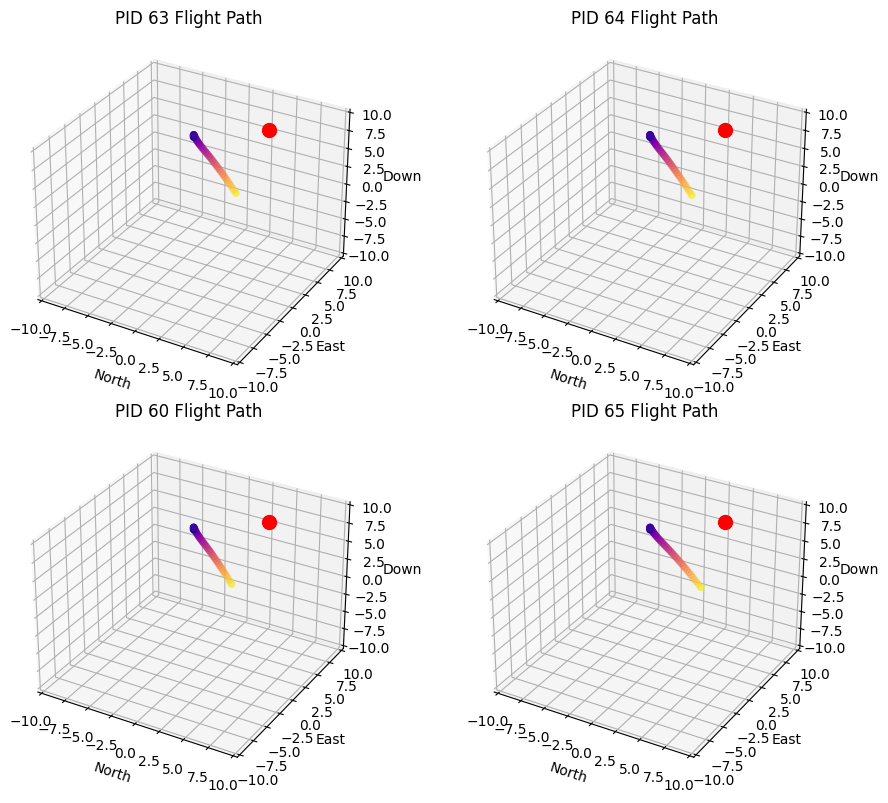

Instance 0: 0.18020256088699374
Instance 1: None
Instance 2: None
Instance 3: 0.1810777560886742
Instance 4: 0.1814322826574321
Instance 5: 0.18125636228867165


TypeError: '>' not supported between instances of 'float' and 'NoneType'

In [6]:
def simulate_drone(pid, out_port, network, result_dict, results_lock):
    try:
        print(f"starting instance {pid} on port {out_port}")
        start_instance(pid, out_port)
        drone_connection = connect(out_port)

        # Print heartbeat information
        while True:
            msg = drone_connection.recv_match(type='HEARTBEAT', blocking=True)
            if not msg:
                print(f"instance {pid} - No heartbeat")
            else:
                print(f"instance {pid} - Heartbeat Recieved!")
                break

        time.sleep(40)

        print(f"instance {pid} - arming throttle in GUIDED mode.")
        arm(drone_connection)

        print(f"instance {pid} - sending takeoff command")
        takeoff(drone_connection, 10)
        
        #time.sleep(8)

        path = []

        for i in range(35):
            north, east, down = get_current_position(drone_connection)

            #print(f'Instance {pid} - North: {north}, East: {east}, Down: {down}')
            
            current_pos = [north, east, down]
            path.append(current_pos)

            with torch.no_grad():
                input_tensor = torch.tensor(current_pos, dtype=torch.float32).unsqueeze(0)
                next_position = network(input_tensor).numpy()[0]  # Remove batch dimension and convert to numpy
                next_position = adjust_output(next_position)

            new_north, new_east, new_down = next_position

            print(f"Instance {pid} sending neurotic waypoint: {new_north}, {new_east}, {new_down}")

            send_waypoint_local(drone_connection, new_north, new_east, new_down)
            time.sleep(1)
        

        print(f"stopping instance {pid}")
        stop_instance(pid)

        result_dict[pid] = path
    
    except Exception as e:
        print(f"Exception in thread {pid}: {e}")
        

def main():
    out_port_base = 14560
    pid_base = 0
    instance_count = 6  # Number of individuals (simulation instances) per epoch
    epochs = 50
    target = [5, 5, 9]
    population_size = instance_count
    mutation_rate = 0.1
    mutation_strength = 0.1
       
    print("Testing selection top 2 guys to crossover instead of top half of population")
    print(f"Mutation rate is {mutation_rate} and mutation strength is {mutation_strength}")

    # Initialize the population
    population = initialize_population(population_size)
    
    for j in range(epochs):
        threads = []
        results = {}
        results_lock = threading.Lock()

        print(f"<----------------------- EPOCH {j} ------------------------->")

        for i, network in enumerate(population):
            pid = pid_base + i
            out_port = out_port_base + i
            # Passing results_lock to ensure it is used in simulate_drone
            t = threading.Thread(target=simulate_drone, args=(pid, out_port, network, results, results_lock))
            t.start()
            threads.append(t)

        for t in threads:
            t.join(timeout=200)
            if t.is_alive():
                print("Warning: Thread timed out and may still be running.")
            else:
                print("Thread has completed execution.")

        fitness_scores = [None] * population_size
        with results_lock:
            for pid, path in results.items():
                index = pid % population_size
                fitness = get_fitness(path, target)
                fitness_scores[index] = fitness
                print(f"Instance: {pid} fitness: {fitness}")

            plot_3d_paths(results)

        population = generate_new_population(population, fitness_scores, mutation_rate, mutation_strength)

        pid_base += instance_count
        out_port_base += instance_count        

if __name__ == "__main__":
    main() 